This is Stock Price prediction part of project using Linear Regression 

In [68]:
import pandas as pd
import numpy as np

1. Select and preprocess stock data

In [40]:
data =  pd.read_csv('/Users/niweichong/Desktop/Git/Tools-Project-Data-Cleaning-master/Tools-Project-Data-Cleaning/Clean_Data_Out.csv')

#select values needed and particular stock, modify the date to trading days
def select_stock(stock_name:str):
    data_col_chosen = data[['Name','open','close','volume',]]
    data_stock_chosen = data_col_chosen.loc[data['Name']==stock_name]
    data_stock_chosen.insert(1, 'trading day', [i+1 for i in range(len(data_stock_chosen['Name']))])
    return data_stock_chosen

#eg. choose 'AAL'
data = select_stock('AAL')

'AAL'

In [54]:
#output to csv file
data.to_csv('%s_preprocessed.csv' %data.iat[0, 0],index= False)

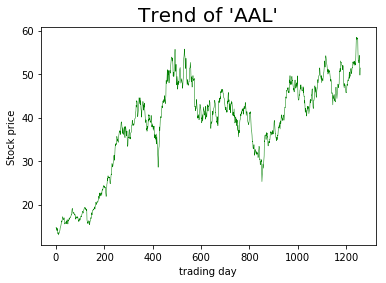

<Figure size 864x1152 with 0 Axes>

In [95]:
import matplotlib.pyplot as plt 

def plot(data):
    
    x=data["trading day"]
    y=data["close"]
    plt.xlabel('trading day')
    plt.ylabel('Stock price')
    
    plt.plot(x, y, '-',linewidth = 0.5, color = 'green' )
  
    # Set title
    plt.title("Trend of '%s'" %(data.iat[0, 0]), fontsize = 20)
    #Output a png file
    plt.savefig('stock_trend_fig_example.png', dpi = 600)
    
    plt.figure(figsize=(12,16))
    return plt.show()

plot(data)

In [69]:
import math
from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import importlib

2. Prepare functions for training and testing

In [82]:
"""
    This function rescales a numpy array from input to target range
    x: data to scale
    input_range: optional input range for data, default 0.0:1.0
    target_range: optional target range for data, default 0.0:1.0
    return: rescaled array, incoming range [min,max]
"""
def scale_range(x, input_range, target_range):

    range = [np.amin(x), np.amax(x)]
    x_std = (x - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    x_scaled = x_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return x_scaled, range

"""
    This function splits the data set into training and testing feature for Linear Regression Model
    stock: whole data set containing ['Open','Close','Volume'] features
    return: X_train : training sets of feature
            X_test : test sets of feature
            y_train: training sets of label
            y_test: test sets of label
            label_range: scaled range of label used in predicting price,
"""
    
def train_test_split_linear_regression(stock):
   
    # Create numpy arrays for features and targets
    feature = []
    label = []

    # Convert dataframe columns to numpy arrays for scikit learn
    for index, row in stock.iterrows():
        # print([np.array(row['trading day'])])
        feature.append([(row['trading day'])])
        label.append([(row['close'])])

    # Regularize the feature and target arrays and store min/max of input data for rescaling later
    feature_bounds = [min(feature), max(feature)]
    feature_bounds = [feature_bounds[0][0], feature_bounds[1][0]]
    label_bounds = [min(label), max(label)]
    label_bounds = [label_bounds[0][0], label_bounds[1][0]]

    feature_scaled, feature_range = scale_range(np.array(feature), input_range=feature_bounds, target_range=[-1.0, 1.0])
    label_scaled, label_range = scale_range(np.array(label), input_range=label_bounds, target_range=[-1.0, 1.0])

    # Define Test/Train Split 80/20
    split = .315
    split = int(math.floor(len(stock['trading day']) * split))

    # Set up training and test sets
    X_train = feature_scaled[:-split]
    X_test = feature_scaled[-split:]

    y_train = label_scaled[:-split]
    y_test = label_scaled[-split:]

    return X_train, X_test, y_train, y_test, label_range


In [83]:
#Load preprocessed data
stock = pd.read_csv('AAL_preprocessed.csv')
display(stock.head())

,Name,trading day,open,close,volume
0,AAL,1,15.07,14.75,8407500
1,AAL,2,14.89,14.46,8882000
2,AAL,3,14.45,14.27,8126000
3,AAL,4,14.30,14.66,10259500
4,AAL,5,14.94,13.99,31879900


In [90]:
#Split data into train and test pair
X_train, X_test, y_train, y_test, label_range= train_test_split_linear_regression(stock)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)
label_range

x_train (863, 1)
y_train (863, 1)
x_test (396, 1)
y_test (396, 1)


[13.02, 58.47]

3. Train a Linear regressor model on training set and get prediction

In [85]:
"""
    This function builds a linear regression model using sklearn.linear_model
    X: Feature dataset
    y: label dataset
    return: a linear regression model
    """
def build_model(X, y):
    
    linear_mod = linear_model.LinearRegression()  # defining the linear regression model
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))
    linear_mod.fit(X, y)  # fitting the data points in the model

    return linear_mod

In [86]:
model = build_model(X_train,y_train)

4. Get prediction on test set

In [87]:
"""
    This function predicts the label for given test sets
    model: a linear regression model
    x: testing features
    label_range: normalised range of label data
    return: predicted labels for given features
    """
def predict_prices(model, x, label_range):
    
    x = np.reshape(x, (x.shape[0], 1))
    predicted_price = model.predict(x)
    predictions_rescaled, re_range = scale_range(predicted_price, input_range=[-1.0, 1.0], target_range=label_range)

    return predictions_rescaled.flatten()

prediction = predict_prices(model,X_test, label_range)

5. Plot the predicted values against actual

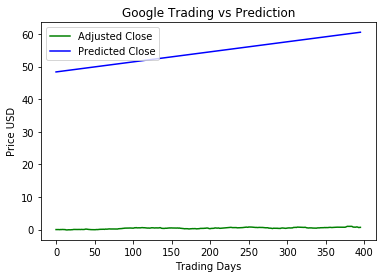

In [94]:
"""
    This function plots train, test and prediction
    actual: DataFrame containing actual data
    prediction: DataFrame containing predicted values
    title:  Title of the plot
    y_label: yLabel of the plot
    x_label: xLabel of the plot
    return: prints a Pyplot against trading days and their close price value
    """
def plot_prediction(actual, prediction, title='Google Trading vs Prediction', y_label='Price USD', x_label='Trading Days'):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values
    plt.plot(actual, 'green', label='Adjusted Close')
    plt.plot(prediction, 'blue', label='Predicted Close')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()

plot_prediction(y_test,prediction)


# plt.plot(y_test,lw=0.5,label="Adjusted actual close",color='green')
# plt.plot(prediction,lw=1,label="Predicted close",color='blue')
# plt.plot(y_test,'-')
# plt.title("Linear Regression Prediction",size=20)
# plt.xlabel('trading day',size=12)
# plt.ylabel('Stock Price',size=12)
# ax.legend(loc='upper left')
